In [47]:
import numpy as np
import tensorflow as tf
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  #mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}
          #"mase": mase.numpy()}

In [48]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [50]:
import pandas as pd
import numpy as np
Data=pd.read_csv("pipo.csv")
X=Data["Index"]
Y=Data["RMS"]
midpoint=int((X.size)/2)
X=X[midpoint:]
Y=Y[midpoint:]

In [51]:
midpoint

492

In [52]:
def make_windows1(y_train,horizonnn,windowww):
    grouped_values=[]
    horizon1=[]
    y_train=np.array(y_train)
    y_train1=np.array(y_train)

    for i in range(0, len(y_train)-(horizonnn)-windowww+1):     #assume horizon to be 7):
            window = y_train[i:i + horizonnn]

            grouped_values.append(window)


           #     for i in range(0, len(y_train)-(horizonnn)):
            horizon = y_train1[i + horizonnn:i+horizonnn+windowww]
            horizon1.append(horizon)





    grouped_values=np.array(grouped_values)
    horizon1=np.array(horizon1)
    return (grouped_values,horizon1)

In [9]:
#import tensorflow as tf
#Preparing the N-Beats model
#class NBeatsBlock(tf.keras.layers.Layer):
#  def __init__(self,input_size:int,
#               theta_size:int,
 #              horizon:int,
  #             n_neurons:int,
   #            n_layers:int,**kwargs):
  #  super().__init__(**kwargs)
  #  self.input_size=input_size
  #  self.theta_size=theta_size
  #  self.horizon=horizon
  #  self.n_neurons=n_neurons
  #  self.n_layers=n_layers

   # self.hidden=[tf.keras.layers.Dense(n_neurons,activation="relu")for _ in range (n_layers)]

    #output of block is a layer with hidden activation
   # self.theta_layer=tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

#  def call(self, inputs): # the call method is what runs when the layer is called
 #   x = inputs
  #  for layer in self.hidden: # pass inputs through each hidden layer
   #   x = layer(x)
    #theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    #backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
#    return backcast, forecast



In [53]:
WINDOW_SIZE=7
HORIZON=1

In [12]:
#dummy_nbeats_block_layer=NBeatsBlock(input_size=WINDOW_SIZE,theta_size=WINDOW_SIZE+HORIZON,horizon=HORIZON,
                                     #n_neurons=128,n_layers=4)

In [13]:
##dummy inputs (have to be same size as input_size)
#dummy_inputs=tf.expand_dims(tf.range(WINDOW_SIZE)+1,axis=0)  #ndim=2

In [14]:
#dummy_inputs

In [15]:
#backcast, forecast = dummy_nbeats_block_layer(dummy_inputs) #dummy inputs to dummy NBeats layer
#tf.squeeze(backcast.numpy())


In [16]:
#forecast

In [54]:
# to make the input data load as fast as possible we will use tf.data
HORIZON=1
WINDOW_SIZE=7 #nbeats works with univariate time-series


In [55]:
import pandas as pd
Data=pd.DataFrame(data=Y,index=X)

In [56]:
Data


,RMS
Index,
492,0.077880
493,0.078123
494,0.076114
495,0.077471
496,0.076934
...,...
979,0.725001
980,0.462012
981,0.483835


In [57]:
DATA_Nbeats=Data.copy()
for i in range(WINDOW_SIZE):
  DATA_Nbeats[f"RMS+{i+1}"]=DATA_Nbeats["RMS"].shift(periods=i+1)

DATA_Nbeats.head()



,RMS,RMS+1,RMS+2,RMS+3,RMS+4,RMS+5,RMS+6,RMS+7
Index,,,,,,,,
492,0.077880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493,0.078123,0.077880,NaN,NaN,NaN,NaN,NaN,NaN
494,0.076114,0.078123,0.077880,NaN,NaN,NaN,NaN,NaN
495,0.077471,0.076114,0.078123,0.077880,NaN,NaN,NaN,NaN
496,0.076934,0.077471,0.076114,0.078123,0.07788,NaN,NaN,NaN


In [58]:
#make features and labels
X=DATA_Nbeats.dropna().drop("RMS",axis=1)
Y=DATA_Nbeats.dropna()["RMS"]

#make train and test sets
split_size = int(len(X) * 0.8)
X_train, Y_train = X[:split_size],Y[:split_size]
X_test, Y_test = X[split_size:], Y[split_size:]
len(X_train), len(Y_train), len(X_test), len(Y_test)

(388, 388, 97, 97)

In [59]:
train_features_dataset=tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset=tf.data.Dataset.from_tensor_slices(Y_train)

test_features_dataset=tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset=tf.data.Dataset.from_tensor_slices(Y_test)

train_dataset=tf.data.Dataset.zip((train_features_dataset,train_labels_dataset))
test_dataset=tf.data.Dataset.zip((test_features_dataset,test_labels_dataset))

#Batch and prefetch
BATCH_SIZE=1024
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [60]:
##setting up hyperparameters for N-BEAT
#values from N-BEATS Paper
N_EPOCHS=5000
N_NEURONS=512
N_LAYERS=4
N_STACKS=30


INPUT_SIZE=WINDOW_SIZE*HORIZON
THETA_SIZE=INPUT_SIZE+HORIZON

INPUT_SIZE,THETA_SIZE

(7, 8)

In [24]:
#preparing for residual connections(residual neural networks)

#make tensors
#before we can craft our N-beats model, we need two layers for the residual connections (subtract and addd).0
tensor_1=tf.range(10)+10
tensor_2=tf.range(10)

#subtract
subtracted=tf.keras.layers.subtract([tensor_1,tensor_2])
#add
added=tf.keras.layers.add([tensor_1,tensor_2])

#get outputs
subtracted,added

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28], dtype=int32)>)

In [25]:
#setup an instance of the nbeats block
#create an input layer for the N-Beats stack
#make the initial backcast and forecasts for the model with the layer created in 1
#use the NBeatsBlock class within the for loop

#tf.random.set_seed(42)

#nbeats_block_layer=NBeatsBlock(input_size=INPUT_SIZE,
 #                              theta_size=THETA_SIZE,
  #                             horizon=HORIZON,
   #                            n_neurons=N_NEURONS,
    #                           n_layers=N_LAYERS,
     #                          name="InitialBlock")

#Create input to stack
#stack_input=tf.keras.layers.Input(shape=(INPUT_SIZE),name="stack_input")

#backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
#residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

#Create stacks of block layers
#for i, _ in enumerate(range(N_STACKS-1)):

#Use NBeatsBlock to calculate the backcast as well as the forecast
 # backcast,block_forecast=NBeatsBlock(
  #   input_size=INPUT_SIZE,
   #  theta_size=THETA_SIZE,
    # horizon=HORIZON,
    # n_neurons=N_NEURONS,
    # n_layers=N_LAYERS,
    # name=f"NBeatsBlock_{i}"
     #)(residuals)   #pass in the residuals

#create the double residual stacking
  #residuals=tf.keras.layers.subtract([residuals,backcast], name=f"subtract_{i}")
  #forecast=tf.keras.layers.add([forecast,block_forecast],name=f"add_{i}")

#put stack model together
#model_7=tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

#compile model with mae loss
#model_7.compile(loss="mae",
 #               optimizer=tf.keras.optimizers.Adam())

#fit the model with EarlyStopping and ReduceLRonPlateau
#model_7.fit(train_dataset,
#            epochs=N_EPOCHS,
 #           validation_data=test_dataset,
  #          verbose=0,
   #         callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    #                                                    patience=200,
     #                                                   restore_best_weights=True),
      #                 tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
       #                                                     patience=100,
        #                                                    verbose=1)])




In [26]:
#model_7.evaluate(test_dataset)

In [61]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        tf.keras.layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [62]:
%%time
ensembele_models=get_ensemble_models(num_iter=5,
                                     num_epochs=1000
                                     )

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 289: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 391: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 491: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 138: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 238: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 122: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 222: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 399: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 589: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 689:

In [ ]:
#ensembele_models

In [63]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [64]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [65]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensembele_models,
                                     data=test_dataset)
ensemble_preds.shape

1/1 [==============================] - 0s 35ms/step


TensorShape([15, 97])

In [66]:
ensemble_results = evaluate_preds(y_true=Y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 0.031050868,
 'mse': 0.0050919848,
 'rmse': 0.071358144,
 'mape': 376.4682}

In [67]:
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95%
lower, upper = get_upper_lower(preds=ensemble_preds)

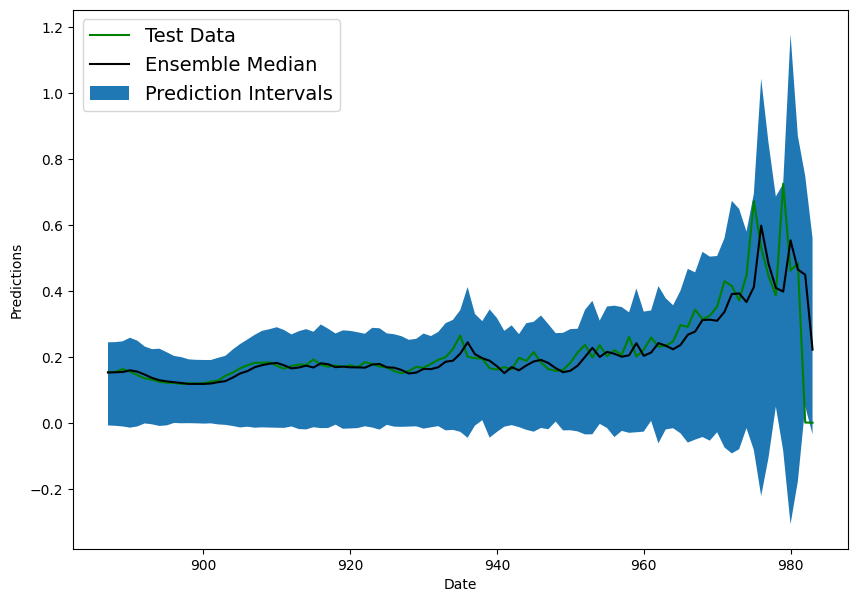

In [68]:

import matplotlib.pyplot as plt# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=0
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], Y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("Predictions")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);